In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from torchmetrics.classification import ConfusionMatrix
import pickle

In [2]:
data = pd.read_csv('data/heart_2.csv') # Downloading the data from https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction
data.shape

(918, 12)

## Summary of the data

In [3]:
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [4]:
data.info() # Getting the summary of the data about which columns are numeric and categorical

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [5]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
FastingBS,918.0,0.233115,0.423046,0.0,0.00,0.0,0.0,1.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2
HeartDisease,918.0,0.553377,0.497414,0.0,0.00,1.0,1.0,1.0


## Distributions

In [6]:
data_num = data.select_dtypes(exclude=['string'])

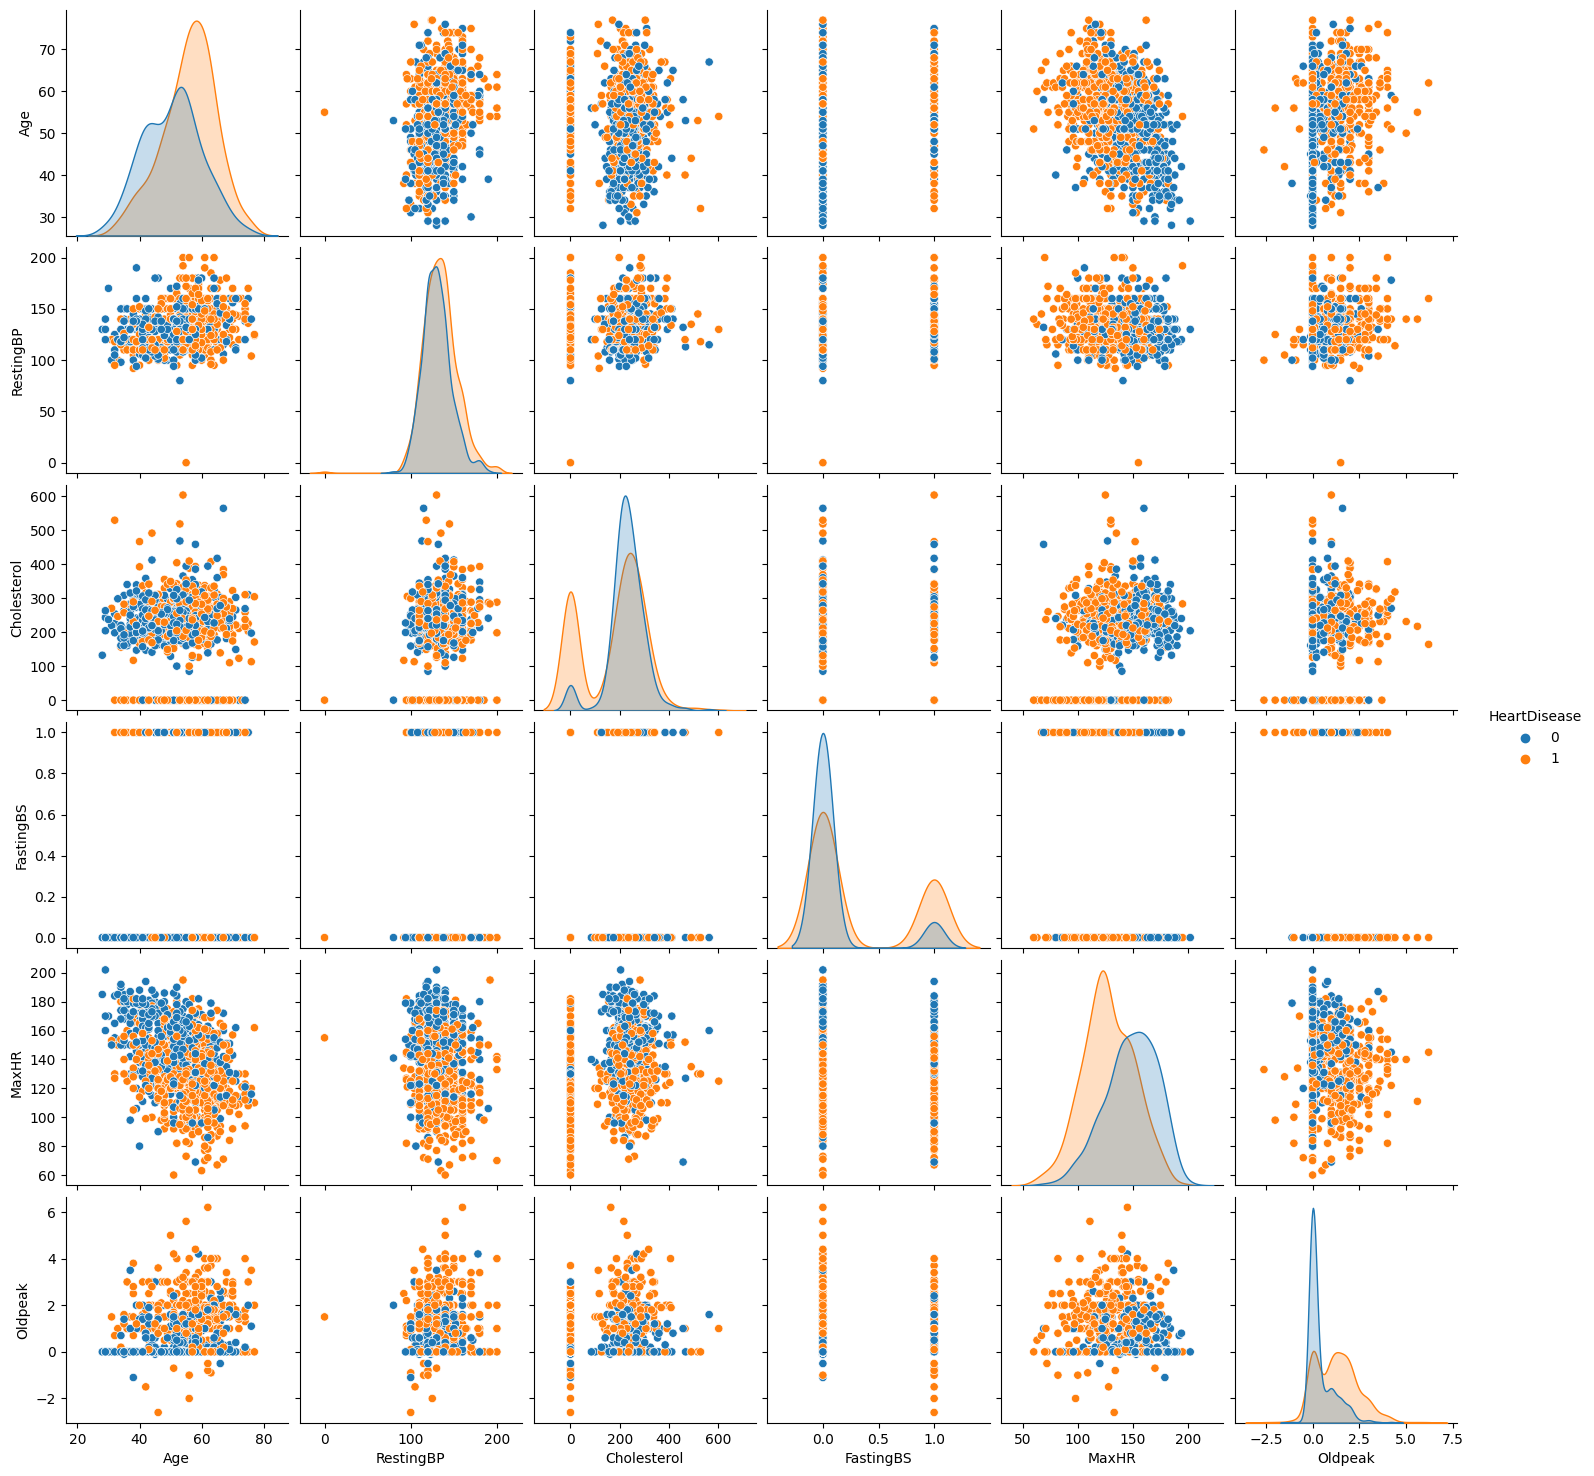

In [7]:
sns.pairplot(data_num, hue="HeartDisease")

## Changing the categorical data

In [8]:
# Changing categorical data into binary 
data['Male?'] = 0
data['Male?'].loc[data['Sex'] == 'M'] = 1
data.drop(columns='Sex', inplace=True)

/var/folders/qj/yzbtrl8d3v1d1kcls_9thcs80000gn/T/ipykernel_2568/4125367477.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Male?'].loc[data['Sex'] == 'M'] = 1


In [9]:
# Changing categorical data into binary 
data['ExerciseAngina?'] = 0
data['ExerciseAngina?'].loc[data['ExerciseAngina'] == 'Y'] = 1
data.drop(columns='ExerciseAngina', inplace=True)

/var/folders/qj/yzbtrl8d3v1d1kcls_9thcs80000gn/T/ipykernel_2568/1267273311.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ExerciseAngina?'].loc[data['ExerciseAngina'] == 'Y'] = 1


In [10]:
# Encoding categorical data into numeric
data = pd.get_dummies(data, columns=['ChestPainType'], dtype=float)

In [11]:
# Encoding categorical data into numeric
data = pd.get_dummies(data, columns=['RestingECG'], dtype=float)

In [12]:
# Encoding categorical data into numeric
data=pd.get_dummies(data,columns=['ST_Slope'], dtype=float)

In [13]:
data.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Male?,ExerciseAngina?,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,1,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,49,160,180,0,156,1.0,1,0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,37,130,283,0,98,0.0,0,1,0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,48,138,214,0,108,1.5,1,0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,54,150,195,0,122,0.0,0,1,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [14]:
data.columns

Index(['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak',
       'HeartDisease', 'Male?', 'ExerciseAngina?', 'ChestPainType_ASY',
       'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA',
       'RestingECG_LVH', 'RestingECG_Normal', 'RestingECG_ST', 'ST_Slope_Down',
       'ST_Slope_Flat', 'ST_Slope_Up'],
      dtype='object')

In [15]:
data = data[['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak',
       'Male?', 'ExerciseAngina?', 'ChestPainType_ASY', 'ChestPainType_ATA',
       'ChestPainType_NAP', 'ChestPainType_TA', 'RestingECG_LVH',
       'RestingECG_Normal', 'RestingECG_ST', 'ST_Slope_Down',
       'ST_Slope_Flat', 'ST_Slope_Up','HeartDisease']]

In [16]:
data.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Male?,ExerciseAngina?,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,HeartDisease
0,40,140,289,0,172,0.0,1,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0
1,49,160,180,0,156,1.0,0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1
2,37,130,283,0,98,0.0,1,0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0
3,48,138,214,0,108,1.5,0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1
4,54,150,195,0,122,0.0,1,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0


## Scaling the data

In [17]:
scaler = MinMaxScaler(feature_range=(0,1))

In [18]:
# In order to train the neural network model, we need to change the data into the range of [0,1]
data[['Age','RestingBP', 'Cholesterol','MaxHR','Oldpeak']] = scaler.fit_transform(data[['Age','RestingBP', 'Cholesterol','MaxHR','Oldpeak']])

In [19]:
data.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Male?,ExerciseAngina?,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,HeartDisease
0,0.244898,0.70,0.479270,0,0.788732,0.295455,1,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0
1,0.428571,0.80,0.298507,0,0.676056,0.409091,0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1
2,0.183673,0.65,0.469320,0,0.267606,0.295455,1,0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0
3,0.408163,0.69,0.354892,0,0.338028,0.465909,0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1
4,0.530612,0.75,0.323383,0,0.436620,0.295455,1,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0


## Correlation Matrix

<Axes: >

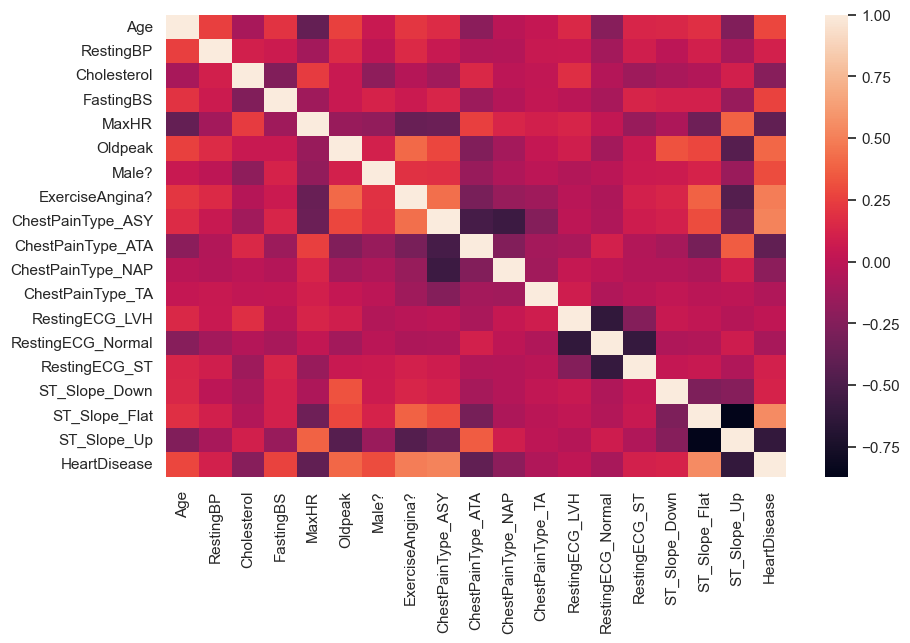

In [20]:
# Making the correlation matrix with the categorical data turned into numeric ones 
sns.set(rc={'figure.figsize':(10,6)}) # Changing the size of figures 
sns.heatmap(data.corr())

## Splitting the data

In [21]:
# Splitting the data into dataset with features to predict the dataset with target feature
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

### Splitting the data into training and testing

In [22]:
# Splitting the data into two datasets with 10% left for final model to test on
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

### Splitting the data into training and validation

In [23]:
# Splitting the training data into two datasets with 10% left for hyperparameter choosing
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42, stratify=y_train)

### Saving the datasets for final test

In [24]:
# Saving the final test data as csv
X_test.to_csv('data/Xtest.csv')
y_test.to_csv('data/ytest.csv')

## Changing to tensor

In [25]:
# Making the tensors of the datasets for modelling
x_train_tensor=torch.from_numpy(X_train.values) 
x_test_tensor=torch.tensor(X_val.values) 
y_train_tensor=torch.tensor(y_train.values) 
y_test_tensor=torch.tensor(y_val.values)

In [26]:
# Changing the data type of datasets to fit them into the model
x_train_tensor=x_train_tensor.float() 
x_test_tensor=x_test_tensor.float() 
y_train_tensor=y_train_tensor.float() 
y_test_tensor=y_test_tensor.float()

## MLP

In [27]:
class MLP_NN(nn.Module):
    def __init__(self,hid_layer1, hid_layer2):
        super(MLP_NN, self).__init__()
        self.fc1 = nn.Linear(18, hid_layer1) # The first hidden layer takes 18 features and takes them into chosen number of neurons of hidden layer
        self.fc2 = nn.Linear(hid_layer1, hid_layer2) # The first hidden layer takes 18 features and takes them into chosen number of neurons of hidden layer
        self.fc3 = nn.Linear(hid_layer2, 1) #This is the output layer and it takes the input from chosen number of neurons of hidden layer, produces the output of one
        self.relu = nn.ReLU() # The activation function on both hidden layers 
        self.sigmoid = nn.Sigmoid() #The activation function, sigmoid is chosen as we have classification problem, it will produce the probability
        
    def forward(self, x):
        # The sequence of the model
        output = self.relu(self.fc1(x))
        output = self.relu(self.fc2(output))
        output = self.fc3(output)
        return output

In [28]:
model = MLP_NN(10,10)
print(model)

MLP_NN(
  (fc1): Linear(in_features=18, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


In [29]:
criterion = nn.BCEWithLogitsLoss() # The loss function for binary classification, which already has sigmoid function. It will be used on output
optimizer = torch.optim.SGD(model.parameters(), lr=0.05) # Function to find global minima

In [30]:
train_loss = [] # The list of train losses for visualisation of model improvement through epochs
train_accuracy = [] # The list of train accuracies for visualisation of model improvement through epochs
model.train() # Training of the model 
epoch = 1000 # The number of epochs
for epoch in range(epoch):
    optimizer.zero_grad() # Turing the weights into zeros
    y_pred = model(x_train_tensor) # Making the predictions
    loss = criterion(y_pred, y_train_tensor.reshape(-1,1)) # Getting the loss
    y_pred_round = torch.round(y_pred) # rounding the probabilities, where numbers higher than 0.5 become 1s, lower become 0s
    correct_results = (y_pred_round == y_train_tensor.reshape(-1,1)).sum().float() # Counting the correct results
    accuracy = correct_results / y_train_tensor.shape[0] # calculating the accuracy
    train_loss.append(loss.item()) # Adding the train loss into the list
    train_accuracy.append(accuracy) # Adding the accuracy into the list
    loss.backward() # backpropogation of the model 
    optimizer.step() # updating the weights

## Training loss and accuracy

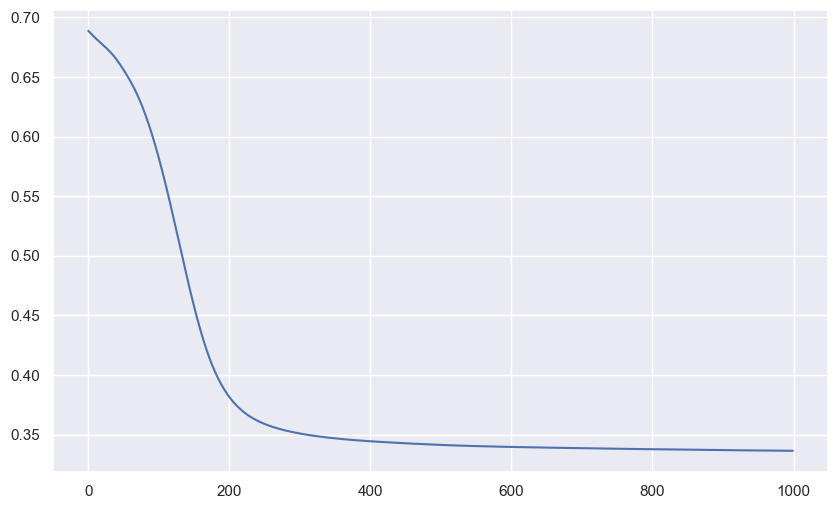

In [31]:
plt.plot(train_loss)
plt.show()

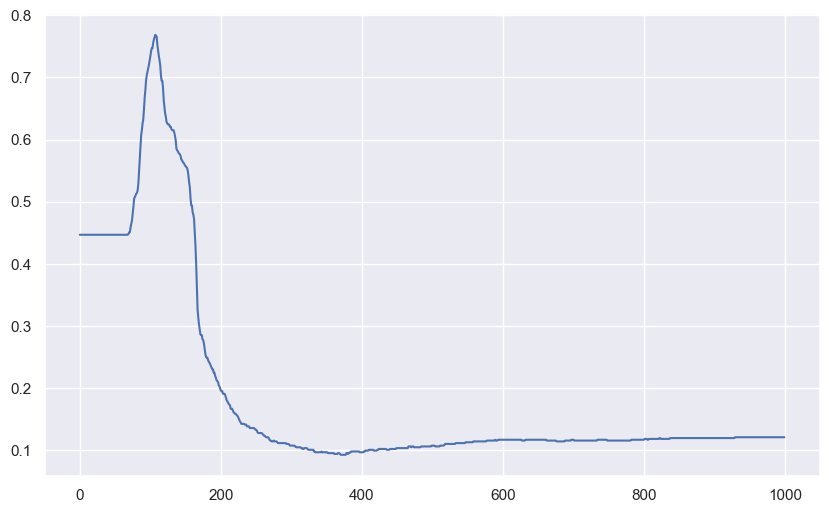

In [32]:
plt.plot(train_accuracy)
plt.show()

In [33]:
model.eval() # Evaluation of the model 
y_pred = model(x_test_tensor) # Getting predictions
after_train = criterion(y_pred, y_test_tensor.reshape(-1,1)) # Getting the loss
print('Test loss after training' , after_train.item())
y_pred_round = torch.round(y_pred) # rounding the values for accuracy 
correct_results = (y_pred_round == y_test_tensor.reshape(-1,1)).sum().float() # counting the number of correctly predicted values
accuracy = correct_results / y_test_tensor.shape[0] # Accuracy of the model
print('Accuracy: {}'.format(accuracy))

Test loss after training 0.2972244322299957
Accuracy: 0.08433734625577927


In [34]:
conf_mat = ConfusionMatrix(task="binary", num_classes=2) # parameters for confusion matrix
cm = conf_mat(y_pred_round, y_test_tensor.reshape(-1,1)) # confusion matrix

[]

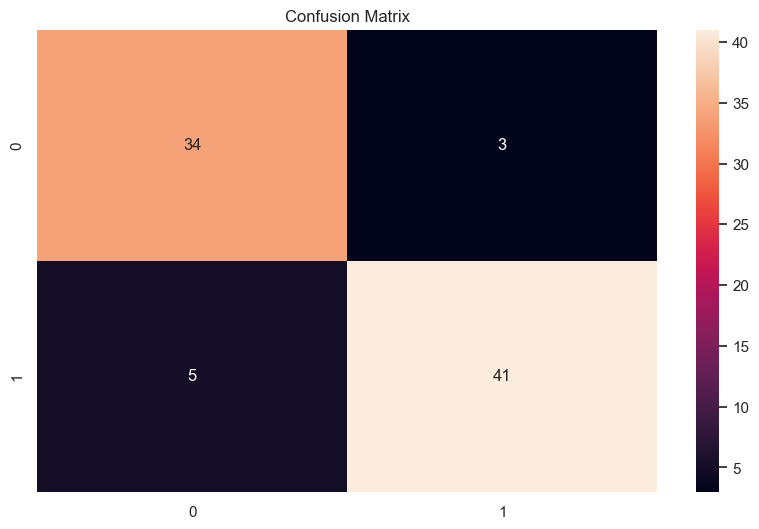

In [35]:
# The confusion matrix of initial model
sns.heatmap(cm, annot=True) 
plt.title('Confusion Matrix')
plt.plot()

## Hyperparameter tuning - MLP

In [36]:
# Hyperparameters
hid_layer = [5,10,15]
l_r = [0.0001, 0.001, 0.01]
momentum = [0.5,0.6,0.7,0.8,0.9]

In [37]:
for hl in hid_layer: # Loop for number of neurons in hidden layers
    for lr in l_r: # Learing rate of the model
        for m in momentum: # Momentum of the model
            model = MLP_NN(hl,hl)
            criterion = nn.BCEWithLogitsLoss()
            optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=m)
            train_loss = []
            train_accuracy = []
            model.train()
            epoch = 1000
            for epoch in range(epoch):
                optimizer.zero_grad()
                y_pred = model(x_train_tensor)
                loss = criterion(y_pred, y_train_tensor.reshape(-1,1)) 
                y_pred_round = torch.round(y_pred) 
                correct_results = (y_pred_round == y_train_tensor.reshape(-1,1)).sum().float() 
                accuracy = correct_results / y_train_tensor.shape[0] 
                train_loss.append(loss.item()) 
                train_accuracy.append(accuracy)
                loss.backward() 
                optimizer.step()
            print('Hidden layers: [',hl,',',hl,'] ', 'Learning rate: ',lr, ' Momentum: ',m)
            print('Train accuracy: {}'.format(max(train_accuracy)))
            model.eval()
            y_pred = model(x_test_tensor)
            after_train = criterion(y_pred, y_test_tensor.reshape(-1,1))
            y_pred_round = torch.round(y_pred)
            correct_results = (y_pred_round == y_test_tensor.reshape(-1,1)).sum().float()
            accuracy = correct_results / y_test_tensor.shape[0]
            print('Accuracy: {}'.format(accuracy))

Hidden layers: [ 5 , 5 ]  Learning rate:  0.0001  Momentum:  0.5
Train accuracy: 0.4468371570110321
Accuracy: 0.4457831382751465
Hidden layers: [ 5 , 5 ]  Learning rate:  0.0001  Momentum:  0.6
Train accuracy: 0.4468371570110321
Accuracy: 0.4457831382751465
Hidden layers: [ 5 , 5 ]  Learning rate:  0.0001  Momentum:  0.7
Train accuracy: 0.4468371570110321
Accuracy: 0.4457831382751465
Hidden layers: [ 5 , 5 ]  Learning rate:  0.0001  Momentum:  0.8
Train accuracy: 0.4468371570110321
Accuracy: 0.4457831382751465
Hidden layers: [ 5 , 5 ]  Learning rate:  0.0001  Momentum:  0.9
Train accuracy: 0.4468371570110321
Accuracy: 0.4457831382751465
Hidden layers: [ 5 , 5 ]  Learning rate:  0.001  Momentum:  0.5
Train accuracy: 0.4468371570110321
Accuracy: 0.4457831382751465
Hidden layers: [ 5 , 5 ]  Learning rate:  0.001  Momentum:  0.6
Train accuracy: 0.4468371570110321
Accuracy: 0.4457831382751465
Hidden layers: [ 5 , 5 ]  Learning rate:  0.001  Momentum:  0.7
Train accuracy: 0.4468371570110321


## Training final model

In [57]:
mlp_model = MLP_NN(10,10)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(mlp_model.parameters(), lr=0.001, momentum=0.8)
train_loss = []
train_accuracy = []
model.train()
epoch = 1000
for epoch in range(epoch):
    optimizer.zero_grad()
    y_pred = mlp_model(x_train_tensor)
    loss = criterion(y_pred, y_train_tensor.reshape(-1,1)) 
    y_pred_round = torch.round(y_pred) 
    correct_results = (y_pred_round == y_train_tensor.reshape(-1,1)).sum().float() 
    accuracy = correct_results / y_train_tensor.shape[0] 
    train_loss.append(loss.item()) 
    train_accuracy.append(accuracy)
    loss.backward() 
    optimizer.step()

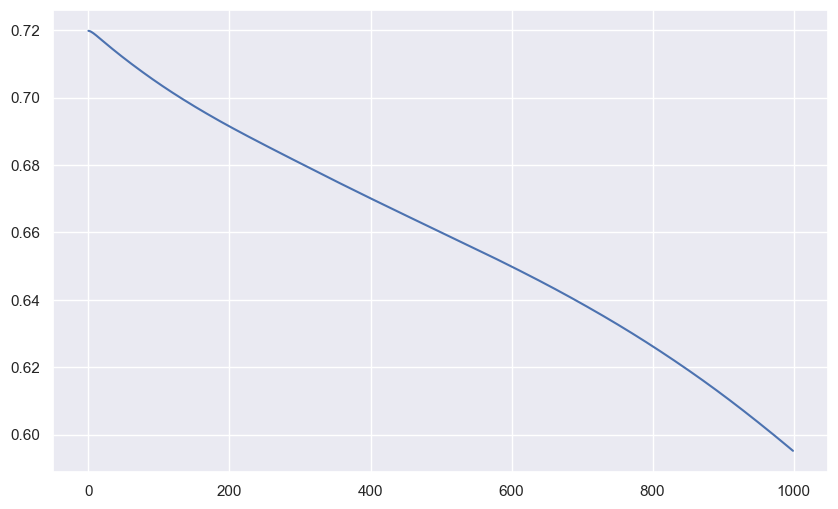

In [58]:
plt.plot(train_loss)
plt.show()

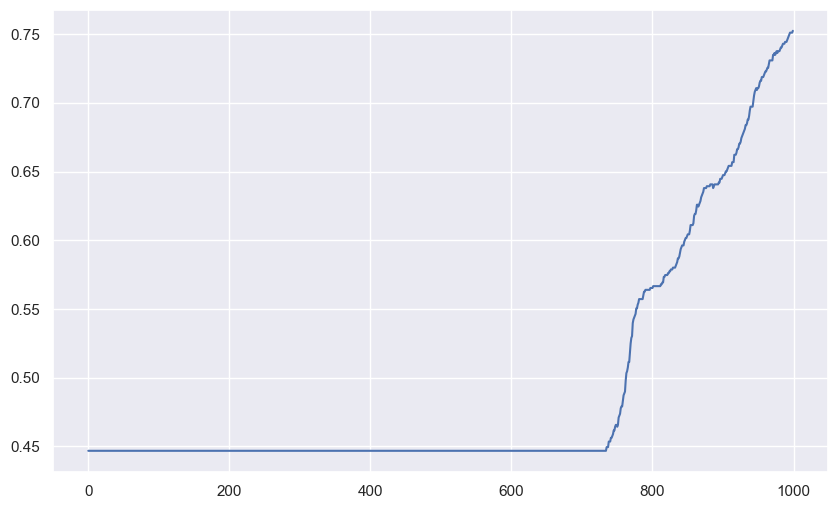

In [59]:
plt.plot(train_accuracy)
plt.show()

In [60]:
mlp_model.eval()
y_pred = mlp_model(x_test_tensor)
after_train = criterion(y_pred, y_test_tensor.reshape(-1,1))
y_pred_round = torch.round(y_pred)
correct_results = (y_pred_round == y_test_tensor.reshape(-1,1)).sum().float()
accuracy = correct_results / y_test_tensor.shape[0]
print('Accuracy: {}'.format(accuracy))

Accuracy: 0.759036123752594


In [61]:
conf_mat = ConfusionMatrix(task="binary", num_classes=2)
cm = conf_mat(y_pred_round, y_test_tensor.reshape(-1,1))

[]

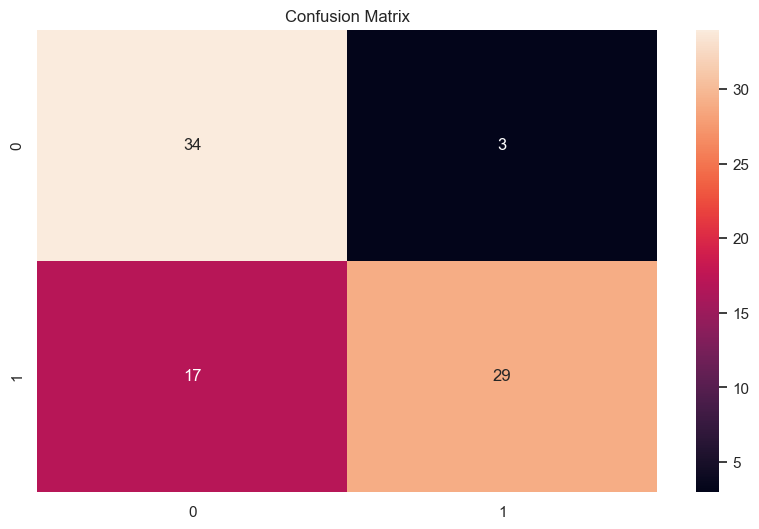

In [62]:
sns.heatmap(cm, annot=True)
plt.title('Confusion Matrix')
plt.plot()

## Saving the model

In [64]:
#torch.save(model.state_dict(), 'mlp_model.pt')
torch.save(mlp_model, 'mlp_model.pt')

# SVC

In [45]:
model_svm = SVC() # Assigning the SVM model 

In [46]:
stratified_data = StratifiedKFold(n_splits = 5) #Stratified cross validation 

In [47]:
# Getting the indeces of rows, which would be used for training the model, based on their class
for train_index, test_index in stratified_data.split(X_train, y_train):
    X_train_fold, y_train_fold = data.iloc[train_index,:-1], data.iloc[train_index,-1]
    X_test_fold, y_test_fold = data.iloc[test_index,:-1], data.iloc[test_index,-1]
    model_svm.fit(X_train_fold,y_train_fold)
    print(model_svm.score(X_test_fold,y_test_fold))

0.9060402684563759
0.9463087248322147
0.7651006711409396
0.8851351351351351
0.7027027027027027


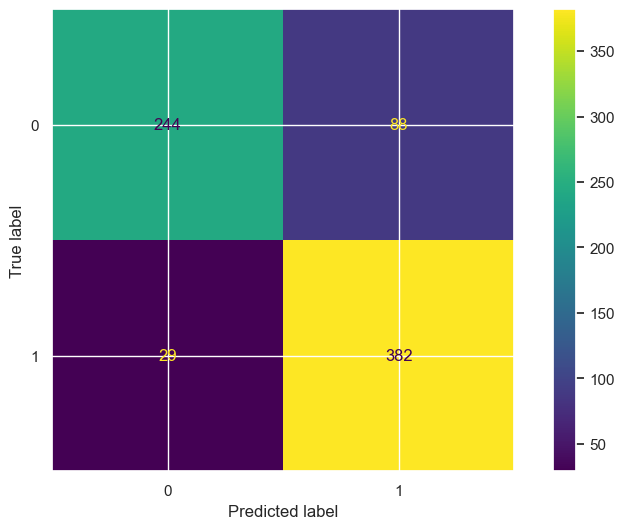

In [48]:
# Fitting the whole training data into the model for confusion matrix
ConfusionMatrixDisplay.from_estimator(model_svm, X_train, y_train)
plt.show()

In [49]:
# Accuracy of the model
model_svm.score(X_val, y_val)

0.891566265060241

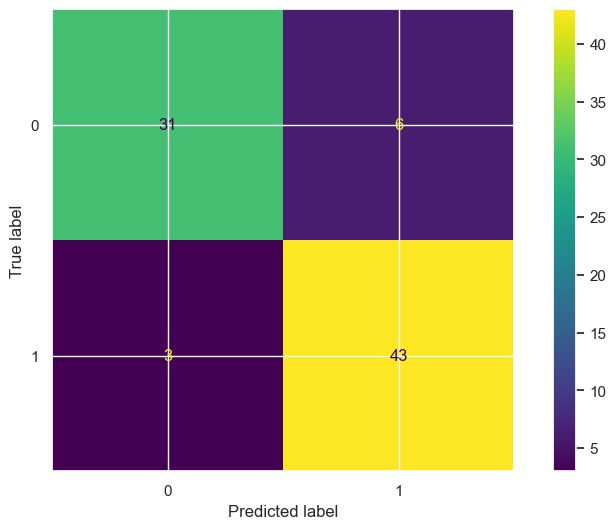

In [50]:
# Confusion matrix for model tested on validation data
ConfusionMatrixDisplay.from_estimator(model_svm, X_val, y_val)

## Hyperparameter tuning - SVC

In [51]:
# Hyperparameters
parameters = {'kernel':('linear','rbf','poly'), 'degree':(0, 1, 2, 3, 4, 5, 6), 'gamma':(0, 0.1, 1, 10)}

In [52]:
model_svm = SVC() # Assigning new model 
svm = GridSearchCV(model_svm, parameters, cv=5) # Fitting the model into grid search for choosing hyperparameters
svm.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'degree': (0, 1, 2, 3, 4, 5, 6),
                         'gamma': (0, 0.1, 1, 10),
                         'kernel': ('linear', 'rbf', 'poly')})

In [53]:
# Best hyperparameters, which will be used for test data
svm.best_params_

{'degree': 3, 'gamma': 0.1, 'kernel': 'poly'}

In [54]:
# Accuracy for training data
svm.score(X_train, y_train)

0.8667563930013459

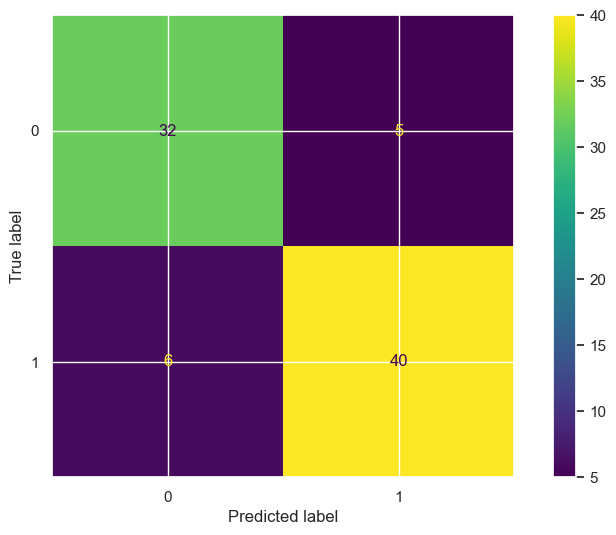

In [55]:
# Confusion matrix for model with hyperparameters tested on validation data
ConfusionMatrixDisplay.from_estimator(svm, X_val, y_val)

## Saving the model

In [56]:
with open('svm_pkl', 'wb') as files:
    pickle.dump(svm, files)